In [30]:
from torchvision.models import vit_b_32, ConvNeXt_Large_Weights
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from torchvision.models import swin_s, Swin_S_Weights, SwinTransformer
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from utils import get_best_available_device
from dataset import ImageDataset
import matplotlib.pyplot as plt

# 1. Get dataset

In [5]:
BATCH_SIZE = 32
device = get_best_available_device()
print("Using device:", device)

dataset = ImageDataset(path="../../data/training/", device="cpu", use_patches=False)
dataloader = iter(DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True))

Using device: cpu


Loading images:   0%|          | 0/134 [00:00<?, ?it/s]

Loading images:   0%|          | 0/134 [00:00<?, ?it/s]

In [6]:
print(f"There are {len(dataloader)} images in the dataset.")

There are 26 images in the dataset.


Index: 362, mod: 2
Index: 182, mod: 2
Index: 441, mod: 3
Index: 595, mod: 1
Index: 200, mod: 2
Index: 462, mod: 0
Index: 675, mod: 3
Index: 623, mod: 5
Index: 495, mod: 3
Index: 86, mod: 2
Index: 411, mod: 3
Index: 184, mod: 4
Index: 110, mod: 2
Index: 372, mod: 0
Index: 165, mod: 3
Index: 106, mod: 4
Index: 676, mod: 4
Index: 328, mod: 4
Index: 219, mod: 3
Index: 437, mod: 5
Index: 643, mod: 1
Index: 271, mod: 1
Index: 576, mod: 0
Index: 791, mod: 5
Index: 210, mod: 0
Index: 563, mod: 5
Index: 28, mod: 4
Index: 377, mod: 5
Index: 385, mod: 1
Index: 415, mod: 1
Index: 689, mod: 5
Index: 796, mod: 4


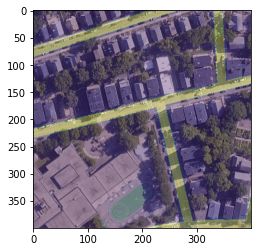

In [7]:
batch = next(dataloader)
images, masks = batch

plt.imshow(images[0].numpy().transpose(1, 2, 0))
plt.imshow(masks[0].numpy().transpose(1, 2, 0), alpha=0.3)
plt.show()

# 2. Create model and load weights

In [ ]:
from typing import List, Optional, Union, Any, Dict
from torchvision.models._api import WeightsEnum
from torchvision.models._utils import V

def _ovewrite_named_param(kwargs: Dict[str, Any], param: str, new_value: V) -> None:
    if param in kwargs:
        if kwargs[param] != new_value:
            raise ValueError(f"The parameter '{param}' expected value {new_value} but got {kwargs[param]} instead.")
    else:
        kwargs[param] = new_value
def _swin_transformer(
    patch_size: List[int],
    embed_dim: int,
    depths: List[int],
    num_heads: List[int],
    window_size: List[int],
    stochastic_depth_prob: float,
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> SwinTransformer:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = IntSwinS(
        patch_size=patch_size,
        embed_dim=embed_dim,
        depths=depths,
        num_heads=num_heads,
        window_size=window_size,
        stochastic_depth_prob=stochastic_depth_prob,
        **kwargs,
    )

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def swin_s(*, weights: Optional[Swin_S_Weights] = None, progress: bool = True, **kwargs: Any) -> SwinTransformer:
    """
    Constructs a swin_small architecture from
    `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows <https://arxiv.org/pdf/2103.14030>`_.
    Args:
        weights (:class:`~torchvision.models.Swin_S_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.Swin_S_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.swin_transformer.SwinTransformer``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/swin_transformer.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.Swin_S_Weights
        :members:
    """
    weights = Swin_S_Weights.verify(weights)

    return _swin_transformer(
        patch_size=[4, 4],
        embed_dim=96,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        window_size=[7, 7],
        stochastic_depth_prob=0.3,
        weights=weights,
        progress=progress,
        **kwargs,
    )

In [ ]:
class IntSwinS(SwinTransformer):

    def forward(self, x):
        self.x_int = [x]
        for i in range(len(self.features)):
            x = self.features[i](x)
            self.x_int.append(x)
        # x = self.x_int[-1]
        # x = self.norm(x)
        # x = x.permute(0, 3, 1, 2)
        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.head(x)
        return x

In [60]:
# weights = ConvNeXt_Small_Weights.IMAGENET1K_V1
# encoder = convnext_small(weights=weights).to("cpu")
weights = Swin_S_Weights.IMAGENET1K_V1
encoder = swin_s(weights=weights).to("cpu")

In [61]:
import json

with open('imagenet_labels.json', 'r') as f:
    labels = json.load(f)["labels"]


In [62]:
preprocess = weights.transforms()

In [63]:
out = encoder(preprocess(images))
# len(encoder.x_int)
for int in encoder.x_int:
    print(int.shape)
out.shape


torch.Size([32, 3, 224, 224])
torch.Size([32, 56, 56, 96])
torch.Size([32, 56, 56, 96])
torch.Size([32, 28, 28, 192])
torch.Size([32, 28, 28, 192])
torch.Size([32, 14, 14, 384])
torch.Size([32, 14, 14, 384])
torch.Size([32, 7, 7, 768])
torch.Size([32, 7, 7, 768])


torch.Size([32, 7, 7, 768])

In [95]:
class PersoDecoder(torch.nn.Module):
    def __init__(self, infer_size):
        super().__init__()
        self.layers = []
        # step size = [B, H, W, C]
        for step in infer_size[-1::-2]:
            print(step.shape)
            self.layers.append(torch.nn.ConvTranspose2d(step.shape[3], step.shape[3]//2, kernel_size=2, stride=2, dilation=1))
        self.convs = []
        for step in infer_size[-1::-2]:
            self.convs.append(torch.nn.Conv2d(step.shape[3] * 2, step.shape[3], 3))
            self.convs.append(torch.nn.Conv2d(step.shape[3], step.shape[3], 3))

        self.last_upscale = torch.nn.ConvTranspose2d(infer_size[-2].shape[3], infer_size[-1].shape[1], 3)
        self.last_convs = torch.nn.Sequential(
            torch.nn.Conv2d(infer_size[-1].shape[1], infer_size[-1].shape[1], 3),
            torch.nn.Conv2d(infer_size[-1].shape[1], infer_size[-1].shape[1], 3)
        )

    def forward(self, x, x_int):
        # print(x.shape)
        for i in range(len(self.layers)):
            x_perm = x_int[i].permute(0, 3, 1, 2)
            x = self.layers[i](x_perm)
            x_int_perm = torch.permute(x_int[-1*(i+1)], 0, 3, 1, 2)
            print(x_int_perm.shape)
            torch._assert(x.shape == x_int_perm.shape, "x and x_int_perm must have the same shape")
            x = torch.cat([x, x_int_perm], dim=1)
            x = self.convs[i * 2](x)
            x = self.convs[i * 2 + 1](x)
        x = self.last_upscale(x)
        x = torch.cat([x, x_int[-1]], dim=1)
        x = self.last_convs(x)
        return x

In [96]:
class unet(torch.nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        encoder_weights=None,
        decoder_weights=None,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        if encoder_weights is not None:
            self.encoder.load_state_dict(encoder_weights)
        if decoder_weights is not None:
            self.decoder.load_state_dict(decoder_weights)

    def forward(self, x):
        # askip on preprocess les images
        x = self.encoder(preprocess(x))
        x = self.decoder(x, self.encoder.x_int)
        return x



    

In [97]:
decoder = PersoDecoder(infer_size=encoder.x_int)

model_unet = unet(
    encoder=encoder,
    decoder=decoder).to(device)

torch.Size([32, 7, 7, 768])
torch.Size([32, 14, 14, 384])
torch.Size([32, 28, 28, 192])
torch.Size([32, 56, 56, 96])
torch.Size([32, 3, 224, 224])


In [98]:
out2 = model_unet(images)

RuntimeError: Given transposed=1, weight of size [768, 384, 2, 2], expected input[32, 7, 7, 768] to have 768 channels, but got 7 channels instead

# 3. Predict features for one image